In [ ]:
import torch 
import torch.nn as nn 
from torchvision import datasets
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
#MOUNTING GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving resnet20-12fca82f.th to resnet20-12fca82f.th


In [ ]:
#READING DATA

path = '/content/gdrive/My Drive/'
#cifar10 = datasets.CIFAR10(path, train = True, download = True) # NOT NECESSARY
#cifar10_test = datasets.CIFAR10(path, train = False, download = False) # NOT NECESSARY


cifar10_tensor = datasets.CIFAR10(path, train = True, download = True, transform = transforms.ToTensor())
cifar10_test_tensor = datasets.CIFAR10(path, train = False, download = False, transform = transforms.ToTensor())


#to_tensor = transforms.ToTensor() 
#cifar10_tensor = to_tensor(cifar10) # FOR A SINGLE IMAGE

Files already downloaded and verified


<br><br><br><br><br><br><br>
***PREPROCESSING***

In [ ]:
# NORMALIZING OUR DATA

imgs = torch.stack([img for img, _ in cifar10_tensor], dim = 3)

mean = imgs.view(3, -1).mean(dim = 1)
std = imgs.view(3, -1).std(dim = 1)

transformed_cifar10 = datasets.CIFAR10(path, train = True, 
                                       transform = transforms.Compose([transforms.ToTensor(), 
                                                                       transforms.Normalize(mean, std)]))

transformed_cifar10_test = datasets.CIFAR10(path, train = False, 
                                            transform = transforms.Compose([transforms.ToTensor(), 
                                                                            transforms.Normalize(mean, std)]))

train, validation = torch.utils.data.random_split(transformed_cifar10, [45000, 5000])

train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = True, drop_last = True)
test_loader = torch.utils.data.DataLoader(transformed_cifar10_test, batch_size = 128, shuffle= True, drop_last = True)   
val_loader = torch.utils.data.DataLoader(validation, batch_size = 128, shuffle = True, drop_last = True)                                                                         

<br><br><br><br><br><br>
***Implementing ResNet***

In [ ]:
class BasicBlock(nn.Module):
    '''
    This block will be used many times throughout the network
    '''

    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1) #THE STRIDE SHOULD BE 2
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample 


    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x) #Batchnorm is used before activation
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)


        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity 
        x = self.relu(x)
        return x 


class ResNet(nn.Module):
    '''
    layers: list (how many times do we want to use basic blocks)
    ResNet 20: [3, 3, 3]
    '''
    def __init__(self, basicblock, layers, img_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(img_channels, 16, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        
        self.layer1 = self._make_layer(basicblock, num_residual_blocks = layers[0], out_channels = 16)# 3 
        self.layer2 = self._make_layer(basicblock, num_residual_blocks = layers[1], out_channels = 32, stride = 2) 
        self.layer3 = self._make_layer(basicblock, num_residual_blocks = layers[2], out_channels = 64, stride = 2)
       
        self.avg_pool = nn.AvgPool2d((8, 8))
        self.fc = nn.Linear(64, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.reshape(x.shape[0], -1)
            
        x = self.fc(x)

        return x 
       

    def _make_layer(self, basicblock, num_residual_blocks, out_channels, stride = 1):

        identity_downsample = None
        layers = [] 
        
        if stride != 1 or self.in_channels != out_channels:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, kernel_size = 1, stride = 2), 
                                                nn.BatchNorm2d(out_channels))
        
        layers.append(basicblock(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels 
        
        for i in range(num_residual_blocks - 1):
            layers.append(basicblock(out_channels, out_channels))

        return nn.Sequential(*layers)



 


In [ ]:
#TRAINING
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock, layers = [3, 3, 3], img_channels = 3, num_classes = 10).to(device)


def training_loop(train_loader, optimizer, model, loss_func, max_epochs = 20, validation_loader = None, 
                  batch_size = 64 , scheduler = None):
   
    #LOSS AND OPTIMIZER ---
    n_batches_train = len(train_loader)
    n_batches_val = len(val_loader)
    n_training_samples = n_batches_train * batch_size
    n_val_samples = n_batches_val * batch_size

    losses = []
    accuracy = []
    val_loss = []
    val_accuracy = []
    for epoch in range(max_epochs):
        running_loss, correct = 0, 0
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available:
                batch = images.to(device)
                labels = labels.to(device)

            #FORWARD PASS    
            outputs = model(batch)
            loss = criterion(outputs, labels)  
            _, predictions =  outputs.max(1)
            correct += int((predictions == labels).sum())
            running_loss += loss.item()
            
            #BACKWARD AND OPTIMZIE 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_epoch = running_loss / n_batches_train
        accuracy_epoch = correct / n_training_samples
        #scheduler.step(loss_epoch)

        losses.append(loss_epoch)
        accuracy.append(accuracy_epoch)

        print('Epoch [{}/{}], Training Accuracy [{:.4f}], Training Loss: {:.4f}'
            .format(epoch + 1, max_epochs, accuracy_epoch, loss_epoch), end = '\t, ')
        
        #VALIDATION 
        if val_loader:
            model.eval()
            running_loss, correct = 0, 0
            for images, labels in val_loader:
                if torch.cuda.is_available():
                    batch = images.to(device)
                    labels = labels.to(device)

                outputs = model(batch)
                loss = criterion(outputs, labels)
                _, predictions = outputs.max(1)
                correct += int((predictions == labels).sum())
                running_loss += loss.item()
        
            loss_val = running_loss / n_batches_val
            accuracy_val = correct / n_val_samples

            val_loss.append(loss_val)
            val_accuracy.append(accuracy_val)
            
            scheduler.step(loss_val)
    
            print('Validation accuracy [{:.4f}], Validation Loss: {:.4f}'
                .format(accuracy_val, loss_val))
    
    #SAVING THE MODEL
    model_save_name = 'resnet20.pt'
    path = F"/content/gdrive/My Drive/{model_save_name}" 
    torch.save(model.state_dict(), path)


    return {'loss': losses, 'accuracy': accuracy, 
                'val_loss': val_loss, 'val_accuracy': val_accuracy}



#CALLING THE TRAINING LOOP--------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay = 1e-4, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-3)
#optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001, weight_decay = 1e-4, momentum = 0.9)

#scheduler = StepLR(optimizer, step_size = 15, gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

history = training_loop(train_loader, optimizer, model, criterion, validation_loader = val_loader, 
                        scheduler = scheduler, max_epochs = 60, batch_size = 128)
                        


Epoch [1/60], Training Accuracy [0.5103], Training Loss: 1.3362	, Validation accuracy [0.5198], Validation Loss: 1.4116
Epoch [2/60], Training Accuracy [0.4105], Training Loss: 1.5911	, Validation accuracy [0.5519], Validation Loss: 1.2422
Epoch [3/60], Training Accuracy [0.5685], Training Loss: 1.1802	, Validation accuracy [0.6102], Validation Loss: 1.0838
Epoch [4/60], Training Accuracy [0.6166], Training Loss: 1.0553	, Validation accuracy [0.6364], Validation Loss: 0.9971
Epoch [5/60], Training Accuracy [0.6529], Training Loss: 0.9591	, Validation accuracy [0.6665], Validation Loss: 0.9494
Epoch [6/60], Training Accuracy [0.6729], Training Loss: 0.9058	, Validation accuracy [0.6787], Validation Loss: 0.9077
Epoch [7/60], Training Accuracy [0.6891], Training Loss: 0.8595	, Validation accuracy [0.6881], Validation Loss: 0.8908
Epoch [8/60], Training Accuracy [0.7097], Training Loss: 0.8070	, Validation accuracy [0.7019], Validation Loss: 0.8317
Epoch [9/60], Training Accuracy [0.7170]

In [ ]:
#TESTING 
correct = 0
total = 0


with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        if torch.cuda.is_available():
            batch = images.to(device)
            labels = labels.to(device)
           
            batch_size = images.shape[0]
            outputs = model(batch)
            _, predictions = outputs.max(1)
            correct += int((predictions == labels).sum())
            total += batch_size

print('Test Accuracy: {:.4f}'.format(correct / total))

Test Accuracy: 0.8154


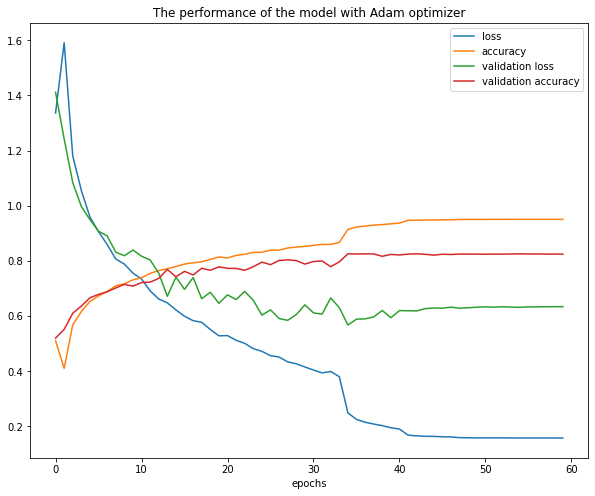

In [ ]:
loss = history['loss']
accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']


plt.figure(figsize = (10, 8))
plt.plot(loss, label = 'loss')
plt.plot(accuracy, label = 'accuracy')
plt.plot(val_loss, label = 'validation loss')
plt.plot(val_accuracy, label = 'validation accuracy')
plt.title('The performance of the model with Adam optimizer')
plt.xlabel('epochs')
plt.legend(loc = 'best')
plt.show()


In [ ]:
#TRAINABLE PARAMETERS
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The total number of parameters for ResNet 20 is: {}'.format(total_params))

The total number of parameters for ResNet 20 is: 273258


<br><br><br><br><br><br><br><br><br><br><br><br><br><br>


In [ ]:
model3 = ResNet(BasicBlock, layers = [3, 3, 3], img_channels = 3, num_classes = 10).to(device)
criterion3 = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 1e-4)
optimizer3 = torch.optim.Adam(model3.parameters(), lr = 0.001, weight_decay = 1e-3)

#scheduler2 = StepLR(optimizer2, step_size = 10, gamma = 0.1)
scheduler3 = ReduceLROnPlateau(optimizer3, 'min', patience = 5)

history3 = training_loop(train_loader, optimizer3, model3, criterion3, validation_loader = val_loader, 
                        scheduler = scheduler3, batch_size = 128, max_epochs = 60)

NameError: ignored

In [ ]:
#TESTING 
correct = 0
total = 0


with torch.no_grad():
    model2.eval()
    for images, labels in test_loader:
        if torch.cuda.is_available():
            batch = images.to(device)
            labels = labels.to(device)
            
            batch_size = images.shape[0]
            outputs = model3(batch)
            _, predictions = outputs.max(1)
            correct += int((predictions == labels).sum())
            total += batch_size

print('Accuracy {:.4f}'.format(correct / total))


Accuracy 0.7936


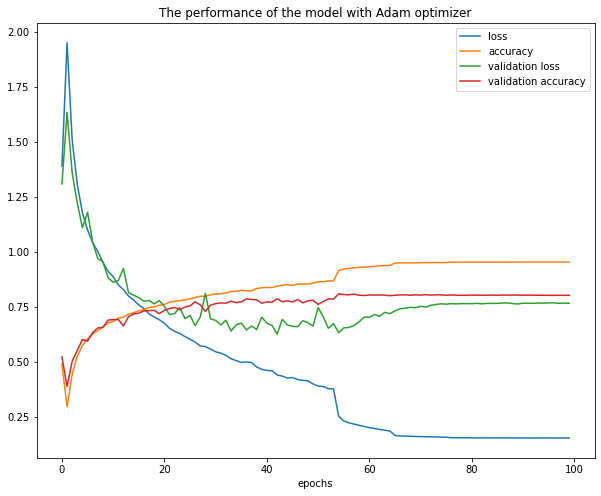

In [ ]:
loss3 = history3['loss']
accuracy3= history3['accuracy']
val_loss3 = history3['val_loss']
val_accuracy3 = history3['val_accuracy']


plt.figure(figsize = (10, 8))
plt.plot(loss3, label = 'loss')
plt.plot(accuracy3, label = 'accuracy')
plt.plot(val_loss3, label = 'validation loss')
plt.plot(val_accuracy3, label = 'validation accuracy')
plt.title('The performance of the model with Adam optimizer')
plt.xlabel('epochs')
plt.legend(loc = 'best')
plt.show()


<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
***ResNet 32***

In [ ]:
model2 = ResNet(BasicBlock, layers = [5, 5, 5], img_channels = 3, num_classes = 10).to(device)
criterion2 = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001, weight_decay = 1e-3)

#scheduler2 = StepLR(optimizer2, step_size = 10, gamma = 0.1)
scheduler2 = ReduceLROnPlateau(optimizer2, 'min', patience = 10)

history2 = training_loop(train_loader, optimizer2, model2, criterion2, validation_loader = val_loader, 
                        scheduler = scheduler2, batch_size = 128, max_epochs = 60)



Epoch [1/60], Training Accuracy [0.4428], Training Loss: 1.5003	, Validation accuracy [0.4052], Validation Loss: 2.0622
Epoch [2/60], Training Accuracy [0.2948], Training Loss: 1.9241	, Validation accuracy [0.4133], Validation Loss: 1.5784
Epoch [3/60], Training Accuracy [0.4395], Training Loss: 1.5159	, Validation accuracy [0.4796], Validation Loss: 1.3951
Epoch [4/60], Training Accuracy [0.5008], Training Loss: 1.3594	, Validation accuracy [0.5413], Validation Loss: 1.2500
Epoch [5/60], Training Accuracy [0.5401], Training Loss: 1.2562	, Validation accuracy [0.5603], Validation Loss: 1.1945
Epoch [6/60], Training Accuracy [0.5717], Training Loss: 1.1706	, Validation accuracy [0.5958], Validation Loss: 1.1068
Epoch [7/60], Training Accuracy [0.5965], Training Loss: 1.1078	, Validation accuracy [0.5715], Validation Loss: 1.1619
Epoch [8/60], Training Accuracy [0.6243], Training Loss: 1.0442	, Validation accuracy [0.6342], Validation Loss: 1.0035
Epoch [9/60], Training Accuracy [0.6404]

In [ ]:
#TRAINABLE PARAMETERS
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)

print('The total number of parameters for ResNet 32 is: {}'.format(total_params))

The total number of parameters for ResNet 32 is: 488618


In [ ]:
#TESTING 
correct = 0
total = 0


with torch.no_grad():
    model2.eval()
    for images, labels in test_loader:
        if torch.cuda.is_available():
            batch = images.to(device)
            labels = labels.to(device)
            
            batch_size = images.shape[0]
            outputs = model2(batch)
            _, predictions = outputs.max(1)
            correct += int((predictions == labels).sum())
            total += batch_size

print('Accuracy {:.4f}'.format(correct / total))


Accuracy 0.7943


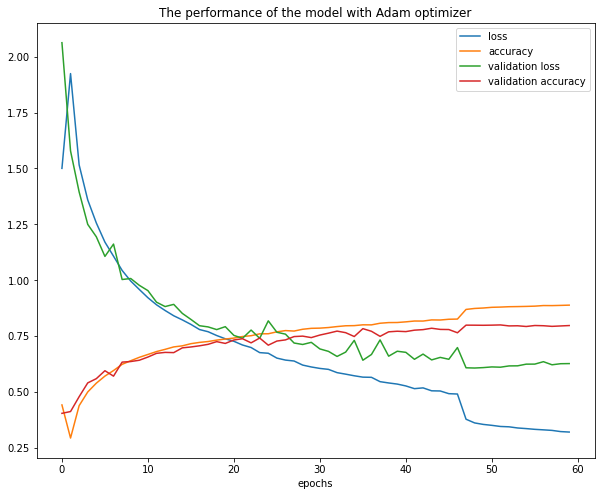

In [ ]:
loss2 = history2['loss']
accuracy2= history2['accuracy']
val_loss2 = history2['val_loss']
val_accuracy2 = history2['val_accuracy']


plt.figure(figsize = (10, 8))
plt.plot(loss2, label = 'loss')
plt.plot(accuracy2, label = 'accuracy')
plt.plot(val_loss2, label = 'validation loss')
plt.plot(val_accuracy2, label = 'validation accuracy')
plt.title('The performance of the model with Adam optimizer')
plt.xlabel('epochs')
plt.legend(loc = 'best')
plt.show()


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
***Scratch***

In [ ]:
#TESTING 
correct = 0
total = 0
features_data = []
predicted_labels = []

with torch.no_grad():
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        batch_size = images.shape[0]
        saved_features, outputs = model(images)
        _, predictions = outputs.max(1)
        
        features_data.append(saved_features) #APPENDING DATA AT EACH ITERATION
        predicted_labels.append(predictions) #APPENDING LABELS AT EACH ITERATION
        corrects += int(predcitions == labels).sum()
        total += batch_size

print('Accuracy {:.2f}'.format(correct / total))


final_data = torch.cat(features_data, dim = 0)
final_labels = torch.unsqueeze(final_labels, dim = 1)

concatenated_data = torch.cat((final_data, final_labels), dim = 1)



In [ ]:
z = torch.arange(12)
z1 = z.view(4, -1)
print(z)
print(z1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])


In [ ]:
#TENSOR IMAGE
#cifar10_tensor[1]

In [ ]:
#RAW IMAGE
#cifar10[1]



In [ ]:
# Your procedeure
model1 = ResNet(BasicBlock, [3, 3, 3], img_channels = 3, num_classes = 10)


#mine = torch.empty((10, 64))
my_data = []
my_labels = []

for i in range(10):
    input1 = torch.randn(2, 3, 32, 32)
    saved_f, output = model2(input1, save_features = True)
    _, pred_labels = output.max(1)
    my_data.append(saved_f)
    my_labels.append(pred_labels)



final_data = torch.cat(my_data, dim = 0)

final_labels = torch.cat(my_labels, dim = 0)
final_labels = torch.unsqueeze(final_labels, dim = 1)


torch.cat((final_data, final_labels), dim = 1).shape

torch.Size([20, 65])

In [ ]:
final_data = torch.stack(my_data, dim = 1)
final_data = torch.squeeze(final_data)

final_labels = torch.stack(my_labels, dim = 0)

torch.cat((final_data, final_labels), dim = 1).shape

In [ ]:
new_labels = torch.unsqueeze(labels1, dim = 1)
cat1 = torch.cat((features, new_labels), dim = 1)

cat1

In [ ]:
a = torch.Tensor([[1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9]])

b = torch.Tensor([[1, 0, 0]])
c = torch.randn(2, 64)

d = torch.Tensor([[1], [0]])

f = torch.cat((c, d), dim = 1)


In [ ]:
#SAVING THE MODEL
model_save_name = 'resnet20.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)


#LOADING YOUR MODEL (first make sure that your google drive is mounted)
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

In [ ]:
labels1 = torch.cat(labels, dim = 0)
labels2 = np.array(labels1)
count, values = np.unique(labels2, return_counts = True)
print(count)
print(values)


[0 1 2 3 4 5 6 7 8 9]
[475 492 531 503 488 514 496 494 502 505]
